In [15]:
import os
import math
import random
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [16]:
# ========== USER CONFIG ==========
# DATA_DIR now accepts a list of paths
DATA_DIRS = [
    r"C:\new pc\Machine learning\CelebA dataset\My dataset\mix images",
    r"C:\new pc\Machine learning\CelebA dataset\My dataset\celebrity images"  # <-- new path for the second image folder
]
# CSV_PATH now accepts a list of paths
CSV_PATHS = [
    r"C:\new pc\Machine learning\CelebA dataset\My dataset\attributes.csv",
    r"C:\new pc\Machine learning\CelebA dataset\My dataset\Celebrity_images_attributes.csv" # <-- new path for the second CSV file
]
FILENAME_COL = "image_id"    # <-- column with image filenames
# List attribute column names (31 attributes). Replace with your CSV's columns if different.
ATTRIBUTES = [
    "attractive", "blurry_image", "sharp_jawline", "high_cheekbones", "smiling", "bald", "receeding_hairline", "long_hair", "curly_hair","grey_hair",
    "black_hair", "has_beard", "patchy_beard", "has_mustache", "well_groomed", "has_makeup", "wearing_glasses", "wearing_hat", "clear_skin",
    "dark_circles", "oily_skin", "thick_eyebrow", "big_eyes", "big_lips", "sharp_nose", "adult", "old", "mouth_open", "male", "double_chin", "veil",
    "dry_skin", "freckle", "wrinkle", "chubby"
    ]
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 0
NUM_EPOCHS = 20
SEED = 42
MODEL_SAVE_PATH = "convnext_tiny_celeb.pth"

# Backbone choices: "convnext_tiny", "convnextv2_tiny", "vit_base_patch16_224"
BACKBONE = "convnext_tiny"
USE_TIMM = True
LR_HEAD = 1e-4
LR_BACKBONE = 1e-5
WEIGHT_DECAY = 1e-4
FREEZE_EPOCHS = 2
# ==================================

# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [17]:
# ======== Utility functions ========
def read_csv(csv_path):
    df = pd.read_csv(csv_path)
    missing_cols = [c for c in [FILENAME_COL] + ATTRIBUTES if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")
    return df

class FacesDataset(Dataset):
    def __init__(self, df, img_dirs: List[str], attr_cols: List[str], transforms=None):
        self.df = df.reset_index(drop=True)
        # Store a list of Path objects for the image directories
        self.img_dirs = [Path(d) for d in img_dirs]
        self.attr_cols = attr_cols
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row[FILENAME_COL]
        img_path = None
        
        # Check each directory for the image file
        for img_dir in self.img_dirs:
            potential_path = img_dir / img_name
            if potential_path.exists():
                img_path = potential_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Image {img_name} not found in any of the specified directories.")
            
        img = Image.open(img_path).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        attrs = torch.tensor(row[self.attr_cols].values.astype(np.float32))
        return img, attrs
def get_transforms(img_size=IMG_SIZE, train=True):
    if train:
        return T.Compose([
            T.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(12),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
            T.RandomErasing(p=0.2, scale=(0.02,0.25), ratio=(0.3, 3.3), value='random')
        ])
    else:
        return T.Compose([
            T.Resize(int(img_size*1.14)),
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

In [18]:
# ======== Prepare data ========
df_list = []
for csv_path in CSV_PATHS:
    df_list.append(read_csv(csv_path))
df = pd.concat(df_list, ignore_index=True)

# Convert -1/1 labels to 0/1
for c in ATTRIBUTES:
    if set(df[c].unique()) <= {-1, 1}:
        df[c] = df[c].apply(lambda x: 1 if x == 1 else 0)

# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, shuffle=True)
train_ds = FacesDataset(train_df, DATA_DIRS, ATTRIBUTES, transforms=get_transforms(train=True))
val_ds = FacesDataset(val_df, DATA_DIRS, ATTRIBUTES, transforms=get_transforms(train=False))
test_ds = FacesDataset(test_df, DATA_DIRS, ATTRIBUTES, transforms=get_transforms(train=False))

# Weighted sampler for training
pos_freq = train_df[ATTRIBUTES].sum(axis=0).values
n_samples = len(train_df)
pos_freq = np.where(pos_freq == 0, 1, pos_freq)
inv_freq = n_samples / (pos_freq * len(ATTRIBUTES))
sample_weights = []
for _, row in train_df[ATTRIBUTES].iterrows():
    labels = row.values
    w = (labels * inv_freq).sum()
    sample_weights.append(float(w) if w > 0 else 0.5)
sample_weights = np.array(sample_weights)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Train: 7832 | Val: 1678 | Test: 1679


In [19]:
# ======== Model ========
def build_model(num_classes: int, backbone="convnext_tiny", pretrained=True, use_timm=True):
    backbone = backbone.lower()
    if use_timm:
        import timm
        model = timm.create_model(backbone, pretrained=pretrained, num_classes=num_classes)
        return model

    raise ValueError("Backbone not supported")

model = build_model(len(ATTRIBUTES), backbone=BACKBONE, pretrained=True, use_timm=USE_TIMM)

model = model.to(device)

In [20]:
# ======== Loss, optimizer, scheduler ========
train_pos = train_df[ATTRIBUTES].sum().values
train_neg = (len(train_df) - train_pos)
pos_weight = torch.tensor(np.where(train_pos==0, 1.0, train_neg / (train_pos + 1e-6)),
                          dtype=torch.float32).to(device)

def focal_bce_with_logits(logits, targets, pos_weight=None, alpha=0.25, gamma=2.0, reduction='mean'):
    if pos_weight is not None:
        bce = F.binary_cross_entropy_with_logits(logits, targets, pos_weight=pos_weight, reduction='none')
    else:
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    probs = torch.sigmoid(logits)
    p_t = probs * targets + (1 - probs) * (1 - targets)
    modulating_factor = (1.0 - p_t) ** gamma
    alpha_factor = targets * alpha + (1 - targets) * (1 - alpha)
    loss = alpha_factor * modulating_factor * bce
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

head_keywords = ("head", "fc", "classifier", "output", "ln", "norm")
head_params, backbone_params = [], []
for name, p in model.named_parameters():
    if any(k in name.lower() for k in head_keywords):
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW([
    {"params": head_params, "lr": LR_HEAD},
    {"params": backbone_params, "lr": LR_BACKBONE}
], weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.amp.GradScaler(device.type, enabled=torch.cuda.is_available())

In [21]:
# ======== Training & evaluation loops ========
def train_one_epoch(model, loader, optimizer, scaler, device, epoch):
    model.train()
    running_loss = 0.0
    device_type = device.type
    pbar = tqdm(loader, desc=f"Train E{epoch}", leave=True, dynamic_ncols=True)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device_type):
            outputs = model(imgs)
            loss = focal_bce_with_logits(outputs, labels, pos_weight=pos_weight)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({"loss": running_loss / ((pbar.n + 1) * loader.batch_size)})
    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device, desc="Eval"):
    model.eval()
    all_targets, all_probs = [], []
    total_loss = 0.0
    for imgs, labels in tqdm(loader, desc=desc, leave=True, dynamic_ncols=True):
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.amp.autocast(device_type=device.type):
            outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        loss = focal_bce_with_logits(outputs, labels, pos_weight=pos_weight)
        total_loss += loss.item() * imgs.size(0)
        all_targets.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

    all_targets = np.vstack(all_targets)
    all_probs = np.vstack(all_probs)

    # Mean accuracy (for reference)
    preds = (all_probs >= 0.5).astype(int)
    per_attr_acc = (preds == all_targets).mean(axis=0)
    mean_acc = per_attr_acc.mean()

    # Mean AUC computation (robust to single-class columns)
    per_attr_auc = []
    for i in range(all_probs.shape[1]):
        y_true = all_targets[:, i]
        y_score = all_probs[:, i]
        if len(np.unique(y_true)) < 2:
            auc = np.nan  # cannot compute AUC for single-class targets
        else:
            auc = roc_auc_score(y_true, y_score)
        per_attr_auc.append(auc)
    per_attr_auc = np.array(per_attr_auc)
    mean_auc = np.nanmean(per_attr_auc)

    return {
        "loss": total_loss / len(loader.dataset),
        "per_attr_acc": per_attr_acc,
        "mean_acc": mean_acc,
        "per_attr_auc": per_attr_auc,
        "mean_auc": mean_auc,
        "all_probs": all_probs,
        "all_targets": all_targets
    }


In [22]:
best_metric = -1
for epoch in range(1, NUM_EPOCHS + 1):
    if epoch <= FREEZE_EPOCHS:
        for name, param in model.named_parameters():
            if any(k in name.lower() for k in head_keywords):
                param.requires_grad = True
            else:
                param.requires_grad = False
    else:
        for p in model.parameters():
            p.requires_grad = True

    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, device, epoch)
    
    if(epoch %3 == 0):
        train_metrics = evaluate(model, train_loader, device, desc="Train")
        print(f"Epoch {epoch} Train Metrics | Train loss: {train_loss:.4f} | "
              f"Train loss: {train_metrics['loss']:.4f} | Mean Acc Train: {train_metrics['mean_acc']:.4f} | Mean Auc Train: {train_metrics['mean_auc']:.4f}" )
    
    
    val_metrics = evaluate(model, val_loader, device, desc="Val")
    scheduler.step()

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Train loss: {train_loss:.4f} | "
          f"Val loss: {val_metrics['loss']:.4f} | Mean val Acc: {val_metrics['mean_acc']:.4f} |Mean val Auc: {val_metrics['mean_auc']:.4f}")

    # Checkpoint based on mean accuracy
    metric_to_check = val_metrics["mean_auc"]
    if not math.isnan(metric_to_check) and metric_to_check > best_metric:
        best_metric = metric_to_check
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✅ Saved best model (Mean Acc={best_metric:.4f}) to {MODEL_SAVE_PATH}")

print("Training completed. Best mean accuracy:", best_metric)

Val: 100%|██████████| 105/105 [00:07<00:00, 13.19it/s]


Epoch 1/20 | Train loss: 0.0708 | Val loss: 0.0571 | Mean val Acc: 0.8190 |Mean val Auc: 0.9112
✅ Saved best model (Mean Acc=0.9112) to convnext_tiny_celeb.pth


Val: 100%|██████████| 105/105 [00:07<00:00, 13.31it/s]


Epoch 2/20 | Train loss: 0.0502 | Val loss: 0.0521 | Mean val Acc: 0.8737 |Mean val Auc: 0.9227
✅ Saved best model (Mean Acc=0.9227) to convnext_tiny_celeb.pth


Train: 100%|██████████| 490/490 [01:01<00:00,  7.99it/s]


Epoch 3 Train Metrics | Train loss: 0.0383 | Train loss: 0.0369 | Mean Acc Train: 0.9022 | Mean Auc Train: 0.9626


Val: 100%|██████████| 105/105 [00:07<00:00, 13.16it/s]


Epoch 3/20 | Train loss: 0.0383 | Val loss: 0.0556 | Mean val Acc: 0.8855 |Mean val Auc: 0.9297
✅ Saved best model (Mean Acc=0.9297) to convnext_tiny_celeb.pth


Val: 100%|██████████| 105/105 [00:07<00:00, 13.28it/s]


Epoch 4/20 | Train loss: 0.0336 | Val loss: 0.0541 | Mean val Acc: 0.8849 |Mean val Auc: 0.9350
✅ Saved best model (Mean Acc=0.9350) to convnext_tiny_celeb.pth


Val: 100%|██████████| 105/105 [00:07<00:00, 13.34it/s]


Epoch 5/20 | Train loss: 0.0281 | Val loss: 0.0638 | Mean val Acc: 0.8857 |Mean val Auc: 0.9331


Train: 100%|██████████| 490/490 [01:04<00:00,  7.55it/s]


Epoch 6 Train Metrics | Train loss: 0.0242 | Train loss: 0.0222 | Mean Acc Train: 0.9295 | Mean Auc Train: 0.9828


Val: 100%|██████████| 105/105 [00:07<00:00, 13.15it/s]


Epoch 6/20 | Train loss: 0.0242 | Val loss: 0.0624 | Mean val Acc: 0.8894 |Mean val Auc: 0.9346


Val: 100%|██████████| 105/105 [00:08<00:00, 12.87it/s]


Epoch 7/20 | Train loss: 0.0204 | Val loss: 0.0715 | Mean val Acc: 0.8942 |Mean val Auc: 0.9346


Val: 100%|██████████| 105/105 [00:08<00:00, 12.95it/s]


Epoch 8/20 | Train loss: 0.0175 | Val loss: 0.0835 | Mean val Acc: 0.9002 |Mean val Auc: 0.9351
✅ Saved best model (Mean Acc=0.9351) to convnext_tiny_celeb.pth


Train: 100%|██████████| 490/490 [01:07<00:00,  7.28it/s]


Epoch 9 Train Metrics | Train loss: 0.0144 | Train loss: 0.0129 | Mean Acc Train: 0.9590 | Mean Auc Train: 0.9929


Val: 100%|██████████| 105/105 [00:07<00:00, 13.13it/s]


Epoch 9/20 | Train loss: 0.0144 | Val loss: 0.0834 | Mean val Acc: 0.9037 |Mean val Auc: 0.9356
✅ Saved best model (Mean Acc=0.9356) to convnext_tiny_celeb.pth


Val: 100%|██████████| 105/105 [00:07<00:00, 13.14it/s]


Epoch 10/20 | Train loss: 0.0125 | Val loss: 0.0951 | Mean val Acc: 0.9065 |Mean val Auc: 0.9335


Val: 100%|██████████| 105/105 [00:08<00:00, 12.98it/s]


Epoch 11/20 | Train loss: 0.0102 | Val loss: 0.1027 | Mean val Acc: 0.9085 |Mean val Auc: 0.9357
✅ Saved best model (Mean Acc=0.9357) to convnext_tiny_celeb.pth


Train: 100%|██████████| 490/490 [01:14<00:00,  6.61it/s]


Epoch 12 Train Metrics | Train loss: 0.0088 | Train loss: 0.0081 | Mean Acc Train: 0.9745 | Mean Auc Train: 0.9966


Val: 100%|██████████| 105/105 [00:11<00:00,  9.31it/s]


Epoch 12/20 | Train loss: 0.0088 | Val loss: 0.1159 | Mean val Acc: 0.9116 |Mean val Auc: 0.9363
✅ Saved best model (Mean Acc=0.9363) to convnext_tiny_celeb.pth


Val: 100%|██████████| 105/105 [00:10<00:00, 10.19it/s]


Epoch 13/20 | Train loss: 0.0074 | Val loss: 0.1232 | Mean val Acc: 0.9107 |Mean val Auc: 0.9349


Val: 100%|██████████| 105/105 [00:08<00:00, 13.11it/s]


Epoch 14/20 | Train loss: 0.0065 | Val loss: 0.1099 | Mean val Acc: 0.9105 |Mean val Auc: 0.9366
✅ Saved best model (Mean Acc=0.9366) to convnext_tiny_celeb.pth


Train: 100%|██████████| 490/490 [01:00<00:00,  8.09it/s]


Epoch 15 Train Metrics | Train loss: 0.0057 | Train loss: 0.0055 | Mean Acc Train: 0.9807 | Mean Auc Train: 0.9983


Val: 100%|██████████| 105/105 [00:07<00:00, 13.22it/s]


Epoch 15/20 | Train loss: 0.0057 | Val loss: 0.1291 | Mean val Acc: 0.9121 |Mean val Auc: 0.9354


Val: 100%|██████████| 105/105 [00:07<00:00, 13.19it/s]


Epoch 16/20 | Train loss: 0.0047 | Val loss: 0.1250 | Mean val Acc: 0.9134 |Mean val Auc: 0.9364


Val: 100%|██████████| 105/105 [00:07<00:00, 13.26it/s]


Epoch 17/20 | Train loss: 0.0046 | Val loss: 0.1307 | Mean val Acc: 0.9154 |Mean val Auc: 0.9371
✅ Saved best model (Mean Acc=0.9371) to convnext_tiny_celeb.pth


Train: 100%|██████████| 490/490 [01:00<00:00,  8.05it/s]


Epoch 18 Train Metrics | Train loss: 0.0040 | Train loss: 0.0039 | Mean Acc Train: 0.9850 | Mean Auc Train: 0.9990


Val: 100%|██████████| 105/105 [00:08<00:00, 13.09it/s]


Epoch 18/20 | Train loss: 0.0040 | Val loss: 0.1316 | Mean val Acc: 0.9149 |Mean val Auc: 0.9366


Val: 100%|██████████| 105/105 [00:07<00:00, 13.26it/s]


Epoch 19/20 | Train loss: 0.0038 | Val loss: 0.1347 | Mean val Acc: 0.9153 |Mean val Auc: 0.9368


Val: 100%|██████████| 105/105 [00:07<00:00, 13.27it/s]

Epoch 20/20 | Train loss: 0.0037 | Val loss: 0.1347 | Mean val Acc: 0.9153 |Mean val Auc: 0.9367
Training completed. Best mean accuracy: 0.9370852391680761


In [27]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [28]:
# ======== Threshold Tuning on Validation Set ========
def tune_thresholds(model, loader, device):
    model.eval()
    all_targets, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Tuning Thresholds", leave=False):
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(labels.numpy())

    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)

    thresholds = np.zeros(all_probs.shape[1])
    for i in range(all_probs.shape[1]):
        best_th, best_acc = 0.5, 0.0
        for th in np.linspace(0.0, 1.0, 101):
            preds = (all_probs[:, i] >= th).astype(int)
            acc = (preds == all_targets[:, i]).mean()
            if acc > best_acc:
                best_acc = acc
                best_th = th
        thresholds[i] = best_th
    return thresholds


@torch.no_grad()
def evaluate_with_thresholds(model, loader, device, thresholds, desc="Eval"):
    model.eval()
    all_targets, all_probs = [], []
    for imgs, labels in tqdm(loader, desc=desc, leave=False):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(labels.numpy())
    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)
    preds = (all_probs >= thresholds[None, :]).astype(int)
    per_attr_acc = (preds == all_targets).mean(axis=0)
    mean_acc = per_attr_acc.mean()
    return mean_acc, per_attr_acc

In [29]:
# ======== Load Best Model ========
print("\n========== Final Evaluation with Threshold Tuning ==========")
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))

# Tune thresholds on validation set
thresholds = tune_thresholds(model, val_loader, device)
print("Tuned thresholds:", np.round(thresholds, 2))

# Evaluate on training and test sets using tuned thresholds
train_mean_acc, train_per_attr_acc = evaluate_with_thresholds(model, train_loader, device, thresholds, desc="Train Eval")
val_mean_acc, val_per_attr_acc = evaluate_with_thresholds(model, val_loader, device, thresholds, desc="Val Eval")
test_mean_acc, test_per_attr_acc = evaluate_with_thresholds(model, test_loader, device, thresholds, desc="Test Eval")

# ======== Print Results ========
print("\nPer-Attribute Accuracies (Train):")
for name, acc, th in zip(ATTRIBUTES, train_per_attr_acc, thresholds):
    print(f"{name:25s}: acc={acc:.4f} (th={th:.2f})")

print(f"\nTrain Mean Accuracy: {train_mean_acc:.4f}")

print("\nPer-Attribute Accuracies (Val):")
for name, acc, th in zip(ATTRIBUTES, val_per_attr_acc, thresholds):
    print(f"{name:25s}: acc={acc:.4f} (th={th:.2f})")

print(f"\nVal Mean Accuracy:  {val_mean_acc:.4f}")

print("\nPer-Attribute Accuracies (Test):")
for name, acc, th in zip(ATTRIBUTES, test_per_attr_acc, thresholds):
    print(f"{name:25s}: acc={acc:.4f} (th={th:.2f})")

print(f"\nTest Mean Accuracy:  {test_mean_acc:.4f}")


========== Final Evaluation with Threshold Tuning ==========


Tuned thresholds: [0.42 0.65 0.6  0.47 0.43 0.93 0.58 0.43 0.61 0.55 0.31 0.3  0.95 0.4
 0.33 0.61 0.38 0.42 0.26 0.55 0.39 0.49 0.65 0.61 0.55 0.27 0.61 0.51
 0.32 0.75 0.74 0.28 0.42 0.37 0.42]



Per-Attribute Accuracies (Train):
attractive               : acc=0.9807 (th=0.42)
blurry_image             : acc=0.9916 (th=0.65)
sharp_jawline            : acc=0.9672 (th=0.60)
high_cheekbones          : acc=0.9920 (th=0.47)
smiling                  : acc=0.9748 (th=0.43)
bald                     : acc=0.9997 (th=0.93)
receeding_hairline       : acc=0.9974 (th=0.58)
long_hair                : acc=0.9761 (th=0.43)
curly_hair               : acc=0.9997 (th=0.61)
grey_hair                : acc=0.9968 (th=0.55)
black_hair               : acc=0.9851 (th=0.31)
has_beard                : acc=0.9937 (th=0.30)
patchy_beard             : acc=0.9543 (th=0.95)
has_mustache             : acc=0.9945 (th=0.40)
well_groomed             : acc=0.9568 (th=0.33)
has_makeup               : acc=0.9872 (th=0.61)
wearing_glasses          : acc=0.9987 (th=0.38)
wearing_hat              : acc=0.9974 (th=0.42)
clear_skin               : acc=0.9598 (th=0.26)
dark_circles             : acc=0.9831 (th=0.55)
oily_

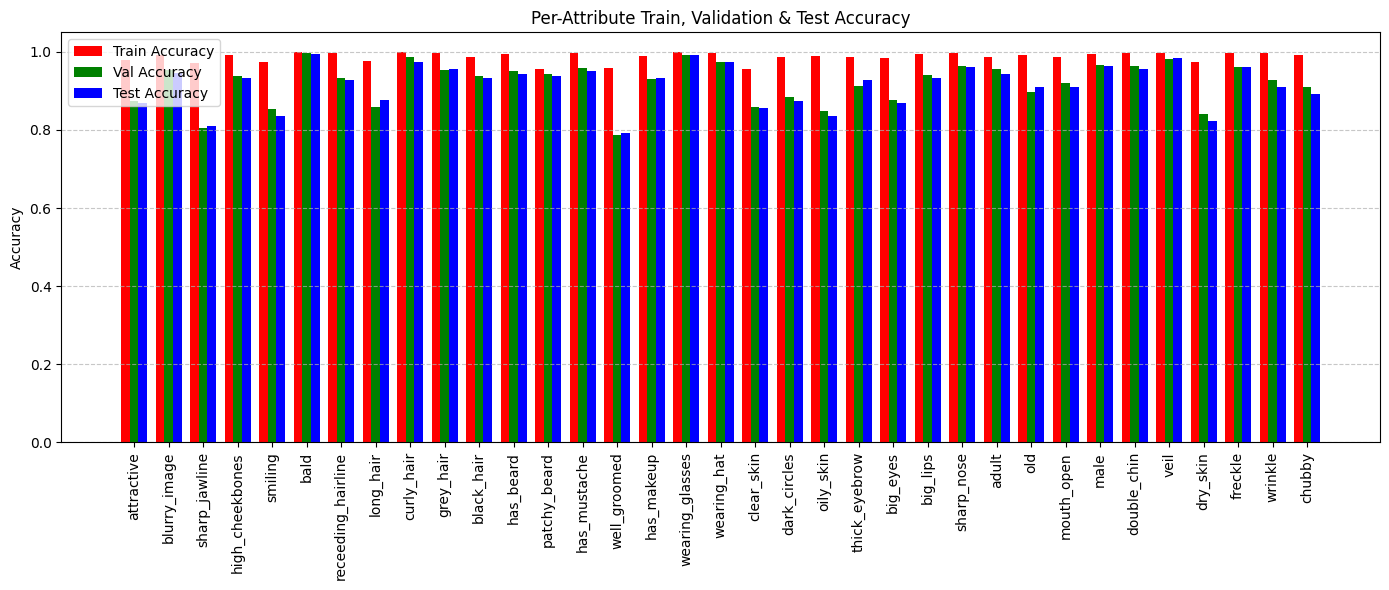

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(ATTRIBUTES))  # label locations
width = 0.25  # width of each bar

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(14, 6))

# Bars for train, val, test accuracy
bars1 = ax.bar(x - width, train_per_attr_acc, width, label='Train Accuracy', color='red')
bars2 = ax.bar(x, val_per_attr_acc, width, label='Val Accuracy', color='green')
bars3 = ax.bar(x + width, test_per_attr_acc, width, label='Test Accuracy', color='blue')


# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(ATTRIBUTES, rotation=90)
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.05)
ax.set_title("Per-Attribute Train, Validation & Test Accuracy")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()